Calculating trend: 100%|███████████████████████████████████████████████████████████| 1800/1800 [05:35<00:00,  5.37it/s]


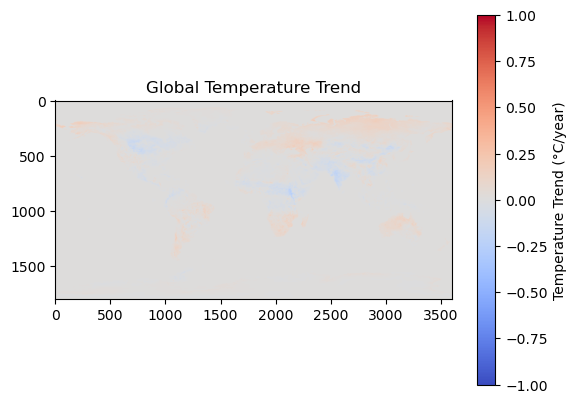

In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from osgeo import gdal
from tqdm import tqdm  # 导入tqdm
import matplotlib.colors as colors

# 设置数据目录和文件名模式
data_dir = 'H:/Global_tree_cover/Temperature/data'
file_pattern = 'MOD_LSTD_M_*_rgb_3600x1800.FLOAT.TIFF'

# 获取匹配文件列表
file_list = sorted([filename for filename in os.listdir(data_dir) if filename.startswith('MOD_LSTD_M_')])

# 读取第一个文件以获取数据尺寸
first_file = gdal.Open(os.path.join(data_dir, file_list[0]))
num_cols = first_file.RasterXSize
num_rows = first_file.RasterYSize

# 创建一个空数组来存储所有数据
all_data = np.empty((num_rows, num_cols, len(file_list)), dtype=np.float32)

# 逐个读取并存储数据
for i, filename in enumerate(file_list):
    file_path = os.path.join(data_dir, filename)
    dataset = gdal.Open(file_path)
    data = dataset.ReadAsArray().astype(np.float32)
    data[data > 1000] = np.nan  # 将填充值替换为 NaN
    all_data[:, :, i] = data

    dataset = None  # 关闭数据集

# 计算温度趋势
trend_map = np.zeros((num_rows, num_cols), dtype=np.float32)
for i in tqdm(range(num_rows), desc='Calculating trend'):  # 封装迭代器
    for j in range(num_cols):
        pixel_values = all_data[i, j, :]
        valid_indices = ~np.isnan(pixel_values)  # 获取非NaN值的索引
        if np.any(valid_indices):  # 如果存在非NaN值
            x = np.arange(len(pixel_values))[valid_indices]
            y = pixel_values[valid_indices]
            slope, _, _, _, _ = linregress(x, y)
            trend_map[i, j] = slope*12

# 绘制全球温度趋势图
# 创建一个两段线性映射，中心为0，边界为-0.1和0.1
norm = colors.TwoSlopeNorm(vmin=-0.5, vcenter=0, vmax=0.5)

# 创建一个新的颜色映射，中心为灰色
cmap = plt.cm.coolwarm
cmap.set_bad(color='gray')

# 使用这个映射和标准化在 imshow 中
img = plt.imshow(trend_map, cmap=cmap, norm=norm)

plt.colorbar(img, label='Temperature Trend (°C/year)')
plt.title('Global Temperature Trend')
plt.show()

In [24]:
trend_map_save = trend_map

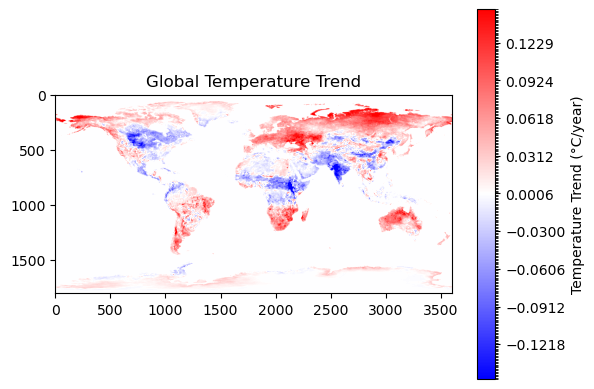

In [44]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 使用内置的 'bwr' 颜色映射
cmap = plt.get_cmap('bwr')

# 创建一个BoundaryNorm对象
bounds = np.linspace(-0.15, 0.15, 256)
norm = colors.BoundaryNorm(bounds, cmap.N)

# 使用自定义的颜色映射和标准化在imshow中
plt.imshow(trend_map, cmap=cmap, norm=norm)
plt.colorbar(label='Temperature Trend (°C/year)')
plt.title('Global Temperature Trend')
plt.show()

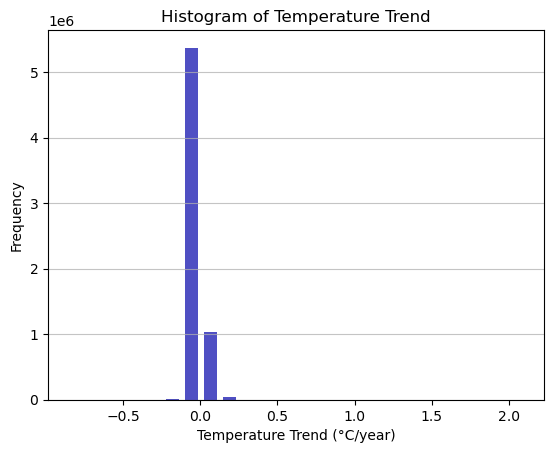

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Flattens the trend_map array and removes NaN values
data = trend_map[~np.isnan(trend_map)].flatten()

# Create the histogram
plt.hist(data, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.7)

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Temperature Trend (°C/year)')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature Trend')

plt.show()

In [ ]:
##### import numpy as np

# Flattens the trend_map array and removes NaN values
data = trend_map[~np.isnan(trend_map)].flatten()
dataU = data[data>0]
dataD = data[data<0]

p99 = np.percentile(dataU, 99)
p01 = np.percentile(dataD, 1)

print(f"The 95th percentile of the temperature trend data is {p99} °C/year.")
print(f"The 5th percentile of the temperature trend data is {p01} °C/year.")

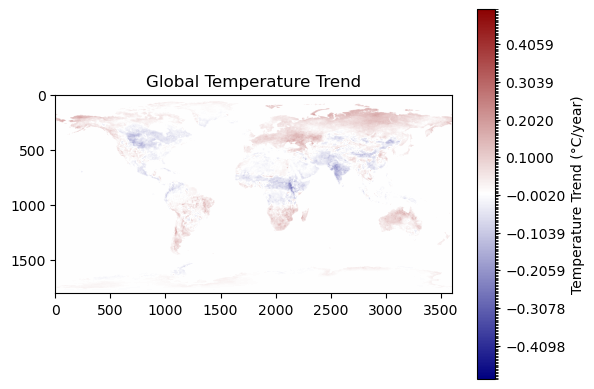

In [32]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np

# 创建一个自定义的颜色映射
cmap = colors.LinearSegmentedColormap.from_list("mycmap", ['navy', 'white', 'darkred'])

# 创建一个BoundaryNorm对象
bounds = np.linspace(-0.5, 0.5, 256)
norm = colors.BoundaryNorm(bounds, cmap.N)

# 使用自定义的颜色映射和标准化在imshow中
plt.imshow(trend_map, cmap=cmap, norm=norm)
plt.colorbar(label='Temperature Trend (°C/year)')
plt.title('Global Temperature Trend')
plt.show()

In [46]:
trend_map.shape

(1800, 3600)

In [47]:
import numpy as np
from osgeo import gdal

# 创建新的数据集
driver = gdal.GetDriverByName('GTiff')
out_dataset = driver.Create('H:/Global_tree_cover/Temperature/data/trend_map.tif', num_cols, num_rows, 1, gdal.GDT_Float32)

# 设置地理转换和投影
out_dataset.SetGeoTransform(first_file.GetGeoTransform())
out_dataset.SetProjection(first_file.GetProjection())

# 写入数据
out_band = out_dataset.GetRasterBand(1)
out_band.WriteArray(trend_map)

# 清理
out_band = None
out_dataset = None